# Plot WOCE Transects

This notebook is based on a script provided by Chris Chapman to plot WOCE transects from ACCESS-OM2 runs, and to compare with observations (gridded WOA13).

### Important Notes
* Running this script at 0.1° requires quite a bit of memory -- I used 24 workers and a full 48-core node on Gadi to run this.
* The figures produced here are not verbatim identical to the ones published in the paper, because we have used a slightly different method to incorporate WOA13 transects into the bias plots. But they are very close ...

In [1]:
%matplotlib inline

import pandas as pd
import intake
catalog = intake.cat.access_nri
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client, progress

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys, os

        os.chdir(os.path.join(os.getcwd(), "cosima-recipes/ACCESS-OM2-GMD-Paper-Figs"))
        sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [4]:
## To implement, use:
client = Client("tcp://10.6.43.39:8786")
client

Client Scheduler: tcp://127.0.0.1:38055 Dashboard: /proxy/8787/status,Cluster Workers: 24 Cores: 48 Memory: 188.57 GiB


In [6]:
KELVIN_TO_CELSIUS = -273.15

PLOT_BIAS = True


MIN_SALT   = 33.5
MAX_SALT   = 36

if PLOT_BIAS:
    MIN_TEMP_BIAS = -2.0
    MAX_TEMP_BIAS =  2.0

    MIN_SALT_BIAS = -1.0
    MAX_SALT_BIAS =  1.0

In [7]:
#==========================================================================#
#Set up the domain limits, colorbar limits, all that stuff, for the
#individual transects 
#==========================================================================#
transect_name_list = ['SR3','P16','A16','I08-09']                 ##'SR1',
transect_lons_list = [140,-150,-25,95]                            ##-65,
transect_lat_limits_list = [[-67,-42],[-76,61],[-75.01,70],[-65,15.1]] ##[-65,-55],
MIN_TEMPERATURE          = [-2,-2,-2,-2]                          ##-2,
MAX_TEMPERATURE          = [13,28,28,28]                          ##7 ,



In [8]:
#==========================================================================#
#Set labels and the cycle lengths for the individual experiments 
#==========================================================================#

labels  = ['(a) ACCESS-OM2','(b) ACCESS-OM2','(c) ACCESS-OM2-025','(d) ACCESS-OM2-025','(e) ACCESS-OM2-01', '(f) ACCESS-OM2-01','(g) WOA13','(h) WOA13']
IAF_CYCLE_LENGTH         = [12,34,150]  

output_figure_path = './'


MAX_DEPTH = 4500

temperature_transect = []
salt_transect        = [] 

MAX_LON_MODEL =   79.5
MIN_LON_MODEL = -279.5

xticks = np.arange(-75,75.1,15)
xtick_labels = []
for i_tick in range(xticks.size):
    if xticks[i_tick]<0:
        xtick_labels.append(str(int(abs(xticks[i_tick]))) + r'$^{\circ}$S')
    elif xticks[i_tick]>0:
        xtick_labels.append(str(int(xticks[i_tick])) + r'$^{\circ}$N')
    else:
        xtick_labels.append(str(int(xticks[i_tick])) + r'$^{\circ}$')



Plotting transect:  SR3
-219.0
Experiment :  1deg_jra55v13_iaf_spinup1_B1
Experiment :  025deg_jra55v13_iaf_gmredi6
Experiment :  01deg_jra55v13_iaf
Plotting transect:  P16
Experiment :  1deg_jra55v13_iaf_spinup1_B1
Experiment :  025deg_jra55v13_iaf_gmredi6
Experiment :  01deg_jra55v13_iaf
Plotting transect:  A16
Experiment :  1deg_jra55v13_iaf_spinup1_B1
Experiment :  025deg_jra55v13_iaf_gmredi6
Experiment :  01deg_jra55v13_iaf
Plotting transect:  I08-09
-264.0
Experiment :  1deg_jra55v13_iaf_spinup1_B1
Experiment :  025deg_jra55v13_iaf_gmredi6
Experiment :  01deg_jra55v13_iaf


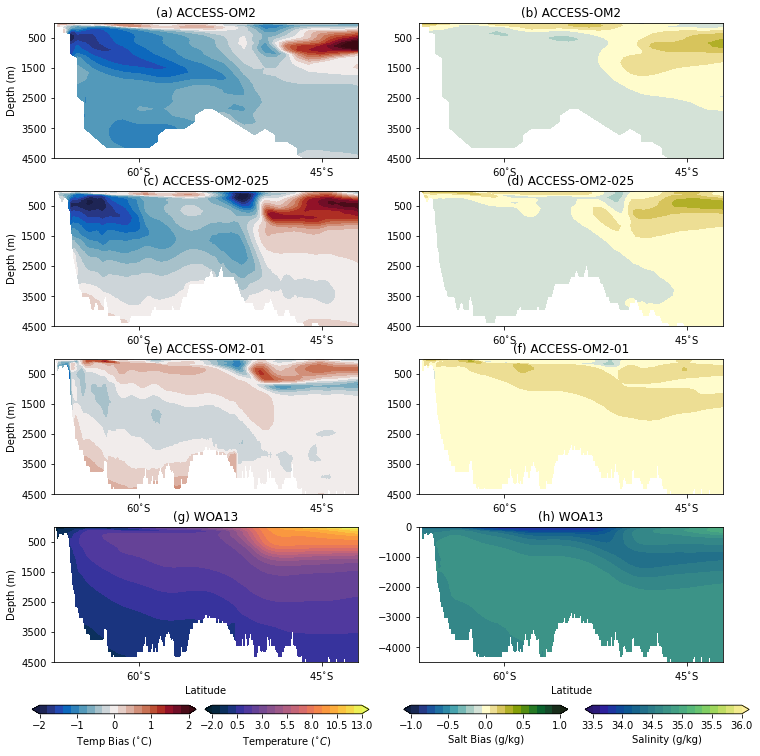

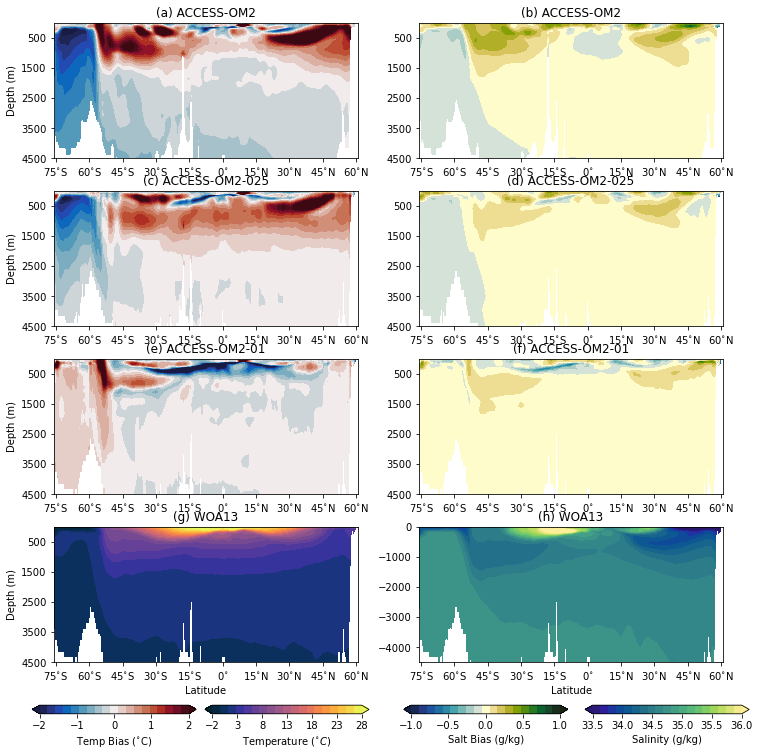

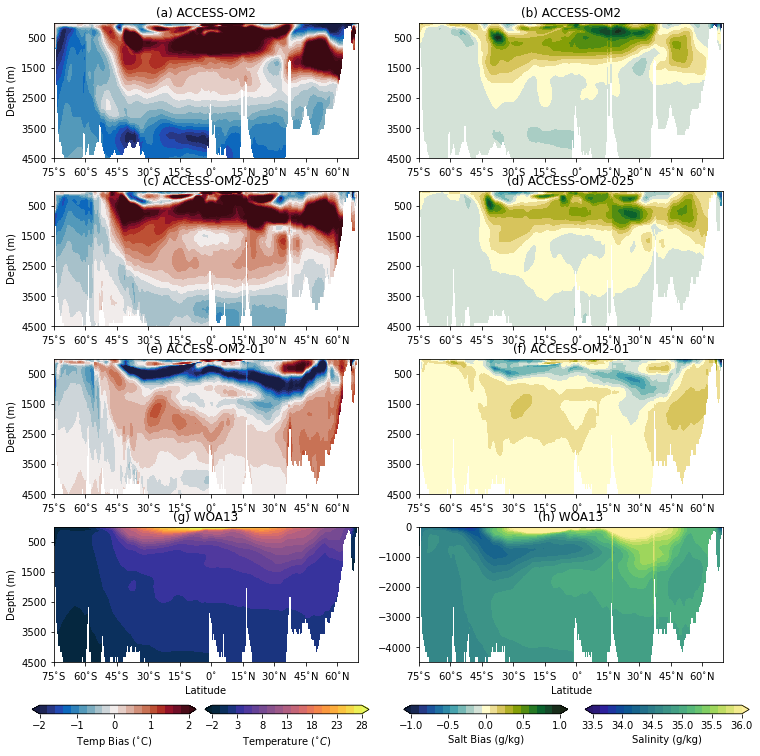

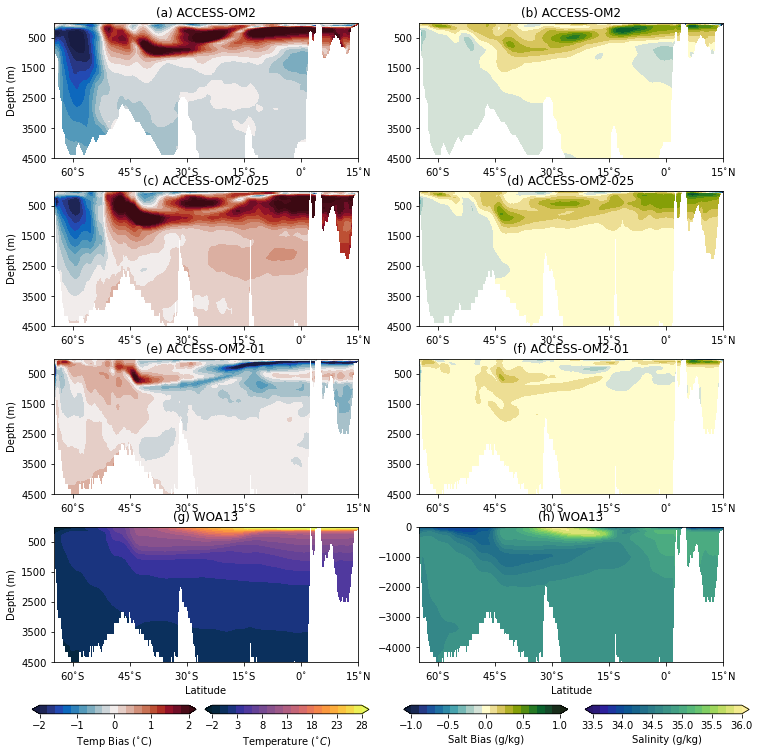

In [9]:
for i_transect in range(0,len(transect_name_list)):
    transect_name = transect_name_list[i_transect]
    transect_lon  = transect_lons_list[i_transect]
    print('Plotting transect: ', transect_name_list[i_transect])

    main_label    = r'Transect ' + transect_name + str(transect_lon)

    if transect_lon>MAX_LON_MODEL:
        transect_lon = (transect_lon-MAX_LON_MODEL) + MIN_LON_MODEL  #Model fields go from -280 to 80, so we need to take into accound the shift
        print(transect_lon)
    #END if transect_lon>MAX_LON_MODEL
    
    #===============================================#
    # Plot Temperature & Salinity Sections
    #===============================================#

    fig = plt.figure(i_transect+1,figsize=(12,12))
    plt.subplots_adjust(bottom=0.14,hspace=0.24)
    
    counter  = 1
    for ekey in exptdata.exptdict.keys():
        
        expt = exptdata.exptdict[ekey]['expt']
        n_files = exptdata.exptdict[ekey]['n_files']
        time_units = exptdata.exptdict[ekey]['time_units']
        offset = exptdata.exptdict[ekey]['offset']
                
        print('Experiment : ', expt)
        
        # Load data, lazily
        cat_subset = catalog[expt]
        var_search = cat_subset.search(variable='temp')
        darray = var_search.to_dask()
        darray = darray['temp']
        temp = darray
        cat_subset = catalog[expt]
        var_search = cat_subset.search(variable='salt')
        darray = var_search.to_dask()
        darray = darray['salt']
        salt = darray
        ds = xr.merge([temp, salt])
        if offset:# shift time axis of darray by 'offset'
            ds = ds.assign_coords(time = ds.time - xr.coding.cftime_offsets.to_offset(offset))
        ds = ds.sel(time=slice(tstart,tend))

        if ekey == '1deg':
            ds_obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/10_KDS50/woa13_ts_??_mom10.nc',chunks={'ZT': None,'GRID_X_T':5})
        if ekey == '025deg':
            ds_obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/025_KDS50/woa13_ts_??_mom025.nc',chunks={'ZT': None,'GRID_X_T':5})
        if ekey == '01deg':
            ds_obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/01/woa13_ts_??_mom01.nc',chunks={'ZT': None,'GRID_X_T':5})
        ds_obs = ds_obs.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
        ds_obs['st_ocean'] = ds.st_ocean
        ds_obs['xt_ocean'] = ds.xt_ocean
        ds_obs['yt_ocean'] = ds.yt_ocean
        ds_obs = ds_obs.mean('time')
        
        temperature = ds.temp.sel(xt_ocean=transect_lon,method='nearest').sel(time=slice(tstart,tend)).mean('time').load() + KELVIN_TO_CELSIUS
        salt = ds.salt.sel(xt_ocean=transect_lon,method='nearest').sel(time=slice(tstart,tend)).mean('time').load()
        
        mask = salt.copy()
        mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
        
        if PLOT_BIAS:
      
            temperature_obs_on_model_grid = ds_obs.temp.sel(xt_ocean=transect_lon,method='nearest').load()
       
            temperature = temperature - temperature_obs_on_model_grid
            color_bar_limits = [MIN_TEMP_BIAS,MAX_TEMP_BIAS]
            colormap         = cm.cm.balance
            cbar_label       = r'Temp Bias ($^{\circ}$C)'
        else:
            color_bar_limits = [MIN_TEMPERATURE[i_transect],MAX_TEMPERATURE[i_transect]]
            colormap         = cm.cm.thermal
            cbar_label       = r'Temperature ($^{\circ}$C)'
            
        ax = fig.add_subplot(4,2,2*counter-1)
        cs_temp = ax.contourf(temperature['yt_ocean'],-temperature['st_ocean'],temperature,np.linspace(color_bar_limits[0],color_bar_limits[1],20),cmap=colormap,extend='both')

        #=================================# 
        #Set up the axes ticks and labels
        #=================================# 
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_xlim(transect_lat_limits_list[i_transect])
 
        ax.set_yticks(np.arange(-MAX_DEPTH,0.1,1000))
        ax.set_yticklabels(np.arange(MAX_DEPTH,0.1,-1000).astype(np.int))
        ax.set_ylim([-MAX_DEPTH,0])
        ax.set_ylabel(r"Depth (m)") 
        #=================================# 
        #Colorbar
        #=================================# 
        if counter == 2:
            ax1 = plt.axes([0.1,0.08,0.19,0.01])
            n_colorbar_ticks = 5
            cbar = fig.colorbar(cs_temp,cax=ax1,orientation='horizontal',ticks=np.linspace(color_bar_limits[0],color_bar_limits[1],n_colorbar_ticks))
            cbar.set_label(cbar_label)

        #=================================#
        #Annotation
        #=================================#
        ax.set_title(labels[2*(counter-1)])
        
        if PLOT_BIAS:
      
            salt_obs_on_model_grid = ds_obs.salt.sel(xt_ocean=transect_lon,method='nearest').load()
            salt                          = salt - salt_obs_on_model_grid
            color_bar_limits = [MIN_SALT_BIAS,MAX_SALT_BIAS]
            colormap         = cm.cm.delta
            cbar_label       = r'Salt Bias (g/kg)'
        else:
            color_bar_limits = [MIN_SALT,MAX_SALT]
            colormap         = cm.cm.haline
            cbar_label       = r'Salinity (g/kg)'

        ax = fig.add_subplot(4,2,2*counter)
        cs_salt = ax.contourf(salt['yt_ocean'],-salt['st_ocean'],salt,np.linspace(color_bar_limits[0],color_bar_limits[1],20),cmap=colormap,extend='both')

        #=================================# 
        # Set up the axes ticks and labels
        #=================================# 
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_xlim(transect_lat_limits_list[i_transect])
 
        ax.set_yticks(np.arange(-MAX_DEPTH,0.1,1000))
        ax.set_yticklabels(np.arange(MAX_DEPTH,0.1,-1000).astype(np.int))
        ax.set_ylim([-MAX_DEPTH,0]) 
                
        ax.set_title(labels[2*(counter-1)+1])
        
        #=================================# 
        # Colorbar
        #=================================# 
        if counter == 2:
            ax3 = plt.axes([0.53,0.08,0.19,0.01])
            n_colorbar_ticks = 5
            cbar = fig.colorbar(cs_salt,cax=ax3,orientation='horizontal',ticks=np.linspace(color_bar_limits[0],color_bar_limits[1],n_colorbar_ticks))
            cbar.set_label(cbar_label)
        
        counter = counter + 1


    ax = fig.add_subplot(427)
    temperature_obs_on_model_grid = temperature_obs_on_model_grid*mask
    cs_temp = ax.contourf(temperature_obs_on_model_grid['yt_ocean'],-temperature_obs_on_model_grid['st_ocean'],temperature_obs_on_model_grid,np.linspace(MIN_TEMPERATURE[i_transect],MAX_TEMPERATURE[i_transect],20),cmap=cm.cm.thermal,extend='both')
    ax2 = plt.axes([0.3,0.08,0.19,0.01])
    n_colorbar_ticks = 7
    cbar = fig.colorbar(cs_temp,cax=ax2,orientation='horizontal',ticks=np.linspace(MIN_TEMPERATURE[i_transect],MAX_TEMPERATURE[i_transect],n_colorbar_ticks))
    cbar.set_label('Temperature ($^{\circ}C$)')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_xlim(transect_lat_limits_list[i_transect])
    ax.set_xlabel("Latitude")

    ax.set_yticks(np.arange(-MAX_DEPTH,0.1,1000))
    ax.set_yticklabels(np.arange(MAX_DEPTH,0.1,-1000).astype(np.int))
    ax.set_ylim([-MAX_DEPTH,0])
    ax.set_ylabel(r"Depth (m)")

    #=================================# 
    # Annotations
    #=================================# 
    ax.set_title(labels[6])
        
    ax = fig.add_subplot(428)
    salt_obs_on_model_grid = salt_obs_on_model_grid*mask
    cs_salt = ax.contourf(salt_obs_on_model_grid['yt_ocean'],-salt_obs_on_model_grid['st_ocean'],salt_obs_on_model_grid,np.linspace(MIN_SALT,MAX_SALT,20),cmap=cm.cm.haline,extend='both')
    

    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_xlim(transect_lat_limits_list[i_transect])
    ax.set_ylim([-MAX_DEPTH,0])
    ax.set_xlabel("Latitude")

    ax4 = plt.axes([0.74,0.08,0.19,0.01])
    n_colorbar_ticks = 6
    cbar = fig.colorbar(cs_salt,cax=ax4,orientation='horizontal',ticks=np.linspace(MIN_SALT,MAX_SALT,n_colorbar_ticks))
    cbar.set_label('Salinity (g/kg)')

    ax.set_title(labels[7])


    output_figure_path = './'
    figure_file_name   = 'Model_vs_WOA13_Temp_Salt_' + transect_name
    if PLOT_BIAS:
        figure_file_name = figure_file_name + '_bias'

    savefigure(output_figure_path + figure_file_name)